In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from scipy.stats import chi2_contingency, f_oneway
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier

In [147]:
df = pd.read_csv('player_injuries_impact.csv')
df.rename(columns={'Date of Injury': 'Injury Date', 'Date of return': 'Return Date'}, inplace=True)

In [148]:
columns_to_drop = ['Name', 'Team Name', 'Season',
                   'Match1_before_injury_Result', 'Match2_before_injury_Result', 'Match3_before_injury_Result',
                   'Match1_before_injury_Opposition', 'Match2_before_injury_Opposition', 'Match3_before_injury_Opposition',
                   'Match1_after_injury_Result', 'Match2_after_injury_Result', 'Match3_after_injury_Result',
                   'Match1_after_injury_Opposition', 'Match2_after_injury_Opposition', 'Match3_after_injury_Opposition',
                   'Match1_missed_match_Result', 'Match2_missed_match_Result', 'Match3_missed_match_Result',
                   'Match1_missed_match_Opposition', 'Match2_missed_match_Opposition', 'Match3_missed_match_Opposition']
df.drop(columns=columns_to_drop, inplace=True)

In [149]:
print(df.columns.tolist())

['Position', 'Age', 'FIFA rating', 'Injury', 'Injury Date', 'Return Date', 'Match1_before_injury_GD', 'Match1_before_injury_Player_rating', 'Match2_before_injury_GD', 'Match2_before_injury_Player_rating', 'Match3_before_injury_GD', 'Match3_before_injury_Player_rating', 'Match1_missed_match_GD', 'Match2_missed_match_GD', 'Match3_missed_match_GD', 'Match1_after_injury_GD', 'Match1_after_injury_Player_rating', 'Match2_after_injury_GD', 'Match2_after_injury_Player_rating', 'Match3_after_injury_GD', 'Match3_after_injury_Player_rating']


In [150]:
# Parse dates and compute days missed
df['Injury Date'] = pd.to_datetime(df['Injury Date'], errors='coerce')
df['Return Date'] = pd.to_datetime(df['Return Date'], errors='coerce')
df['Days missed'] = (df['Return Date'] - df['Injury Date']).dt.days

In [151]:
# Clean missing/invalid
required_cols = ['Days missed', 'Age', 'FIFA rating', 'Position', 'Injury']
df.dropna(subset=required_cols, inplace=True)
df = df[df['Days missed'] >= 0]

In [152]:
# Create severity category using days missed to determine the severity
def categorize_severity(days):
    if days <= 7:
        return 'Low'
    elif days <= 30:
        return 'Moderate'
    else:
        return 'Severe'

df['Severity'] = df['Days missed'].apply(categorize_severity)

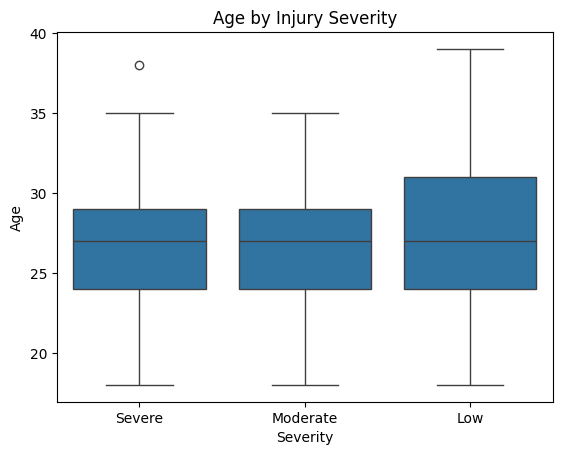

In [153]:
# Boxplots
sns.boxplot(x='Severity', y='Age', data=df)
plt.title('Age by Injury Severity')
plt.show()

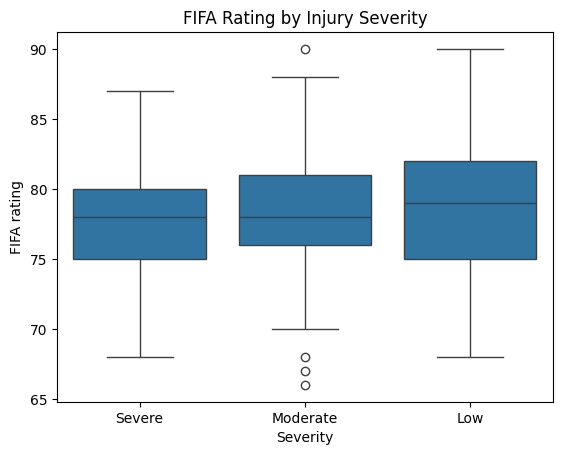

In [154]:
sns.boxplot(x='Severity', y='FIFA rating', data=df)
plt.title('FIFA Rating by Injury Severity')
plt.show()

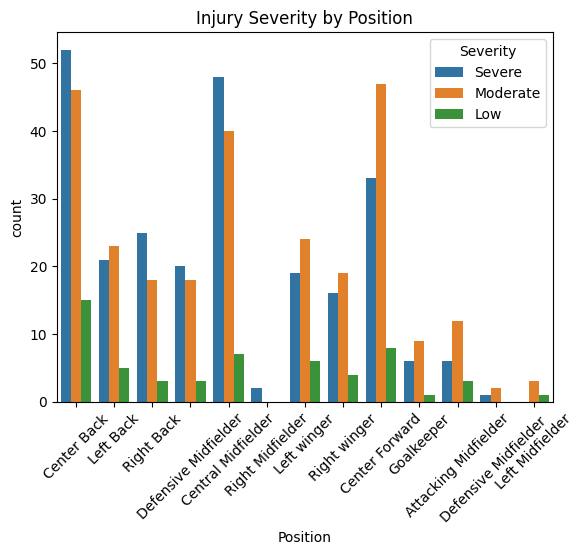

In [155]:
sns.countplot(x='Position', hue='Severity', data=df)
plt.title('Injury Severity by Position')
plt.xticks(rotation=45)
plt.show()

In [156]:
#No association
contingency = pd.crosstab(df['Position'], df['Severity'])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"Chi-square (Position vs Severity): p = {p:.4f}")

Chi-square (Position vs Severity): p = 0.7609


In [157]:
# Not a factor when it comes to injury severity
f_age, p_age = f_oneway(*[df[df['Severity'] == s]['Age'] for s in ['Low', 'Moderate', 'Severe']])
print(f"ANOVA (Age vs Severity): p = {p_age:.4f}")

ANOVA (Age vs Severity): p = 0.7836


In [158]:
# Weak but statistically significant association with injury severity
f_rating, p_rating = f_oneway(*[df[df['Severity'] == s]['FIFA rating'] for s in ['Low', 'Moderate', 'Severe']])
print(f"ANOVA (Rating vs Severity): p = {p_rating:.4f}")

ANOVA (Rating vs Severity): p = 0.0470


In [159]:
df['Injury Encoded'] = LabelEncoder().fit_transform(df['Injury'])

#Player age is significantly associated with certain injuries amongst younger and older players.
groups_age = [df[df['Injury Encoded'] == val]['Age'] for val in df['Injury Encoded'].unique()]
f_age_type, p_age_type = f_oneway(*groups_age)
print(f"ANOVA: Age vs Injury Type — F = {f_age_type:.2f}, p = {p_age_type:.4f}")

#FIFA Rating holds a significant relationship with certain injuries.
groups_rating = [df[df['Injury Encoded'] == val]['FIFA rating'] for val in df['Injury Encoded'].unique()]
f_rating_type, p_rating_type = f_oneway(*groups_rating)
print(f"ANOVA: FIFA Rating vs Injury Type — F = {f_rating_type:.2f}, p = {p_rating_type:.4f}")


ANOVA: Age vs Injury Type — F = 1.68, p = 0.0001
ANOVA: FIFA Rating vs Injury Type — F = 1.31, p = 0.0260


In [160]:
# Posiition is not significantly significant for types of injuries.
contingency_type = pd.crosstab(df['Position'], df['Injury'])
chi2_type, p_type, _, _ = chi2_contingency(contingency_type)
print(f"Chi-square Test: Position vs Injury Type — Chi2 = {chi2_type:.2f}, p = {p_type:.4f}")


Chi-square Test: Position vs Injury Type — Chi2 = 1351.97, p = 0.9245


In [161]:
le_pos = LabelEncoder()
df['Position Encoded'] = le_pos.fit_transform(df['Position'])

le_sev = LabelEncoder()
df['Severity Encoded'] = le_sev.fit_transform(df['Severity'])

In [162]:
#Severity Prediction
X = df[['Age', 'FIFA rating', 'Position Encoded']]
y = df['Severity Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [163]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

In [164]:
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name} - Severity Prediction:")
    print(classification_report(y_test, preds, target_names=le_sev.classes_))


Random Forest - Severity Prediction:
              precision    recall  f1-score   support

         Low       0.18      0.25      0.21         8
    Moderate       0.47      0.36      0.41        61
      Severe       0.45      0.56      0.50        45

    accuracy                           0.43       114
   macro avg       0.37      0.39      0.37       114
weighted avg       0.44      0.43      0.43       114


Gradient Boosting - Severity Prediction:
              precision    recall  f1-score   support

         Low       0.33      0.25      0.29         8
    Moderate       0.46      0.38      0.41        61
      Severe       0.38      0.49      0.43        45

    accuracy                           0.41       114
   macro avg       0.39      0.37      0.38       114
weighted avg       0.42      0.41      0.41       114


Logistic Regression - Severity Prediction:
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00         8
    M

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

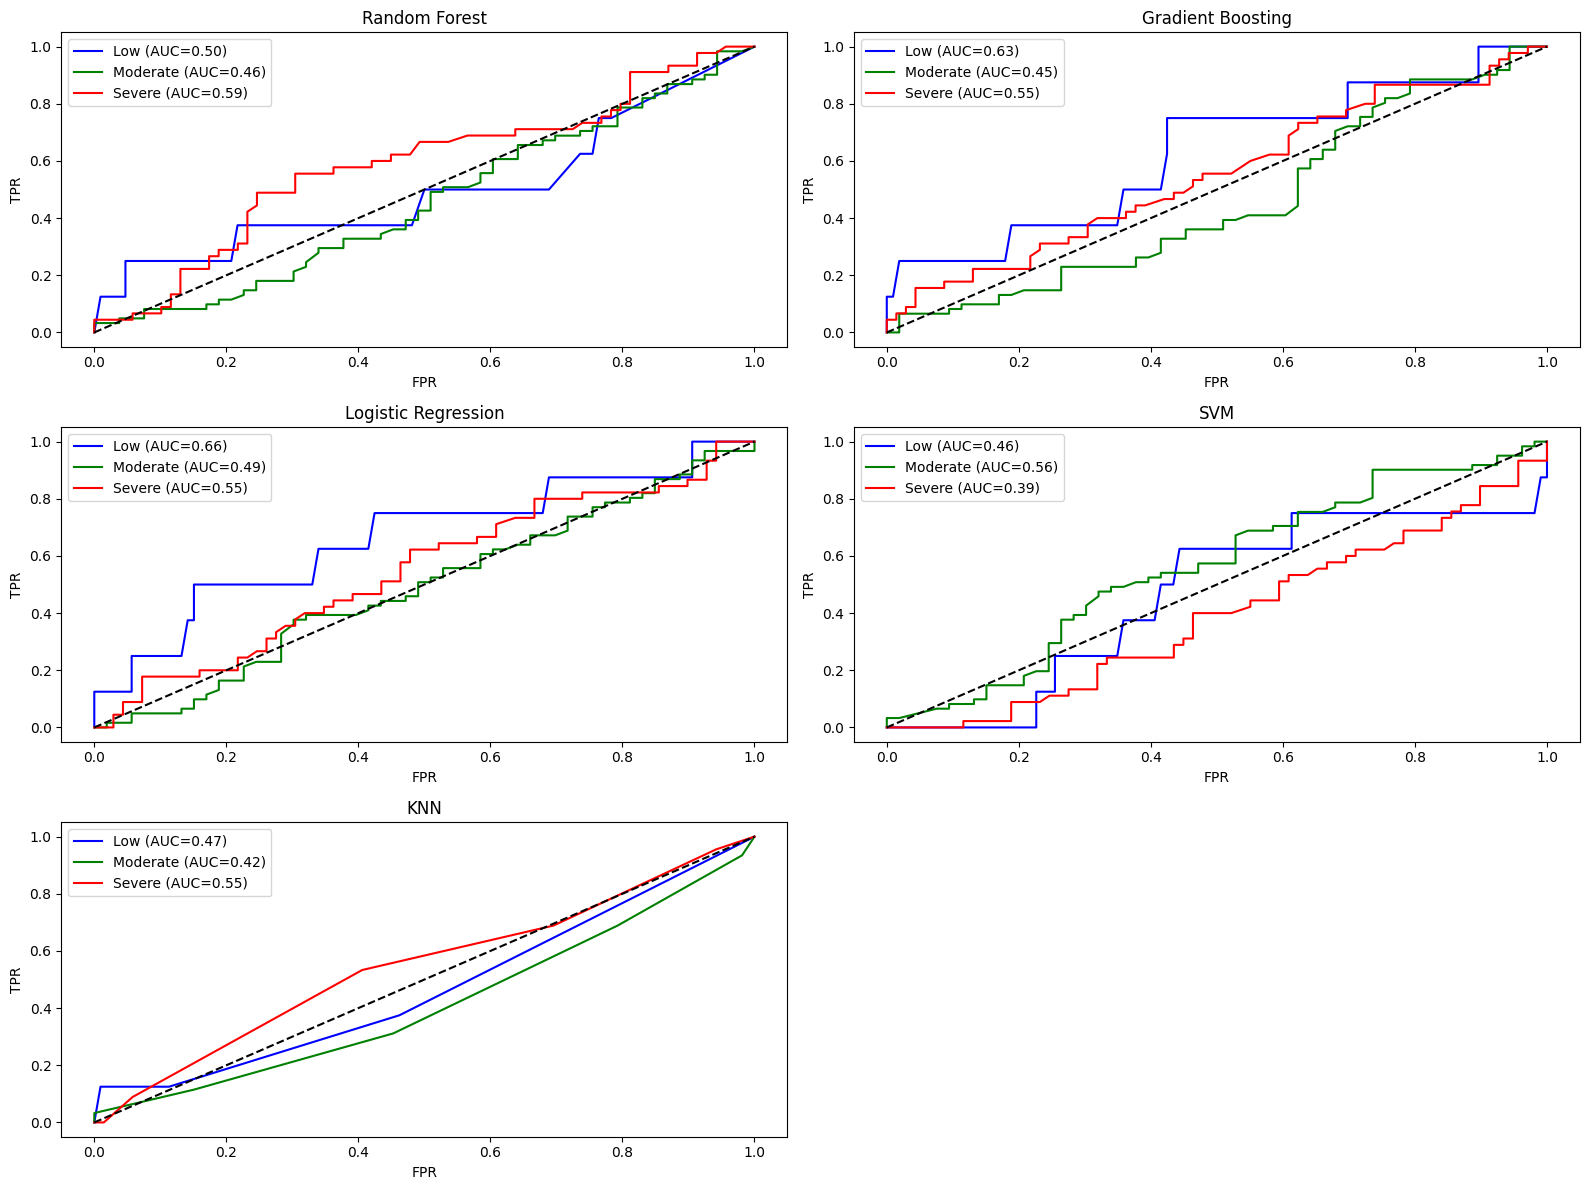

In [165]:
y_bin = label_binarize(df['Severity Encoded'], classes=np.unique(y))
X_scaled = StandardScaler().fit_transform(X)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_scaled, y_bin, test_size=0.2, random_state=42)

plt.figure(figsize=(16, 12))
for i, (name, base_model) in enumerate(models.items(), 1):
    model = OneVsRestClassifier(base_model)
    model.fit(X_train_bin, y_train_bin)
    y_score = model.predict_proba(X_test_bin)
    plt.subplot(3, 2, i)
    for j, color in zip(range(3), cycle(['blue', 'green', 'red'])):
        fpr, tpr, _ = roc_curve(y_test_bin[:, j], y_score[:, j])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, label=f"{le_sev.classes_[j]} (AUC={auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(name)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
plt.tight_layout()
plt.show()

In [166]:
# Interpretation of results:
# Best Performing Model Overall: Logistic Regression for Low
# Across all models, AUC is highest for Low which means it was easier for the models to identify short-term injuries
# SVM and KNN are not suitable for this task (basically random)

In [167]:
#Injury Type Prediction
X_type = df[['Age', 'FIFA rating', 'Position Encoded']]
y_type = df['Injury Encoded']
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_type, y_type, test_size=0.2, random_state=42)

# Train this model to reuse it for feature importance
model_type = RandomForestClassifier(n_estimators=100)
model_type.fit(X_train_t, y_train_t)


RandomForestClassifier()

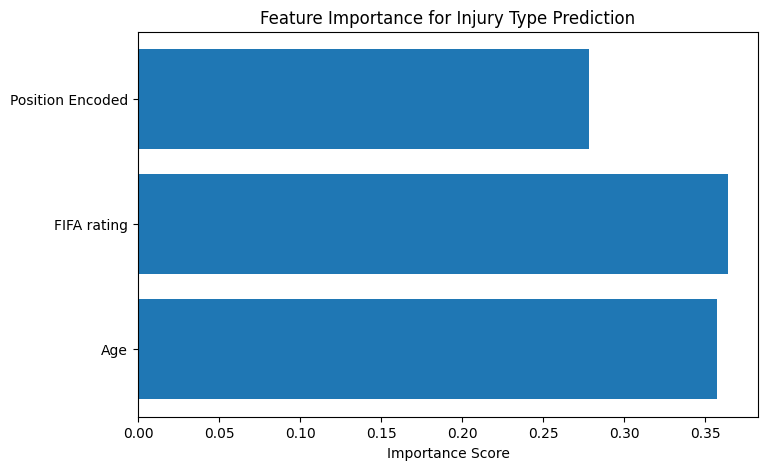

In [168]:
# Get feature importances from trained model
importances = model_type.feature_importances_
features = X_type.columns

# Plot
plt.figure(figsize=(8, 5))
plt.barh(features, importances)
plt.title("Feature Importance for Injury Type Prediction")
plt.xlabel("Importance Score")
plt.show()

In [169]:
#Age is most influential in predicting injury type

In [170]:
# Models to compare
models_type = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

results_type = []

for name, model in models_type.items():
    model.fit(X_train_t, y_train_t)
    y_pred = model.predict(X_test_t)
    acc = accuracy_score(y_test_t, y_pred)
    f1 = f1_score(y_test_t, y_pred, average='weighted')
    results_type.append({'Model': name, 'Accuracy': acc, 'F1 Score': f1})
    print(f"\n{name} - Injury Type Prediction:")
    print(classification_report(y_test_t, y_pred))

# Display comparison
results_df_type = pd.DataFrame(results_type).sort_values(by='F1 Score', ascending=False)
print("\nModel Comparison for Injury Type Prediction:\n", results_df_type)



Random Forest - Injury Type Prediction:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00        12
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         3
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         0
          24       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         3
          26       0.00      0.00      0.00         2
          27       0.00      0.00      0.00         1
          28       0.00      0.00      0.00         0
          29       0.27      0.24      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_


Gradient Boosting - Injury Type Prediction:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00        12
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         0
          18       0.00      0.00      0.00         3
          21       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         0
          24       0.00      0.00      0.00         0
          25       0.00      0.00      0.00         3
          26       0.00      0.00      0.00         2
          27       0.00      0.00      0.00         1
          28       0.00      0.00   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_


Logistic Regression - Injury Type Prediction:
              precision    recall  f1-score   support

           5       0.00      0.00      0.00        12
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         3
          21       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         3
          26       0.00      0.00      0.00         2
          27       0.00      0.00      0.00         1
          29       0.16      0.76      0.27        17
          30       0.00      0.00      0.00         4
          31       0.00      0.00      0.00         1
          32       0.00      0.00      0.00         2
          33       0.00      0.00      0.00         1
          34       0.00      0.00 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [171]:
# No model is a good prediction of accuracy or precision across all injury types

/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 10 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 54 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 59 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 74 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 76 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 85 is present in all training examples.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/multiclass.py:90: UserWarning: Label not 87 is present in all training examp

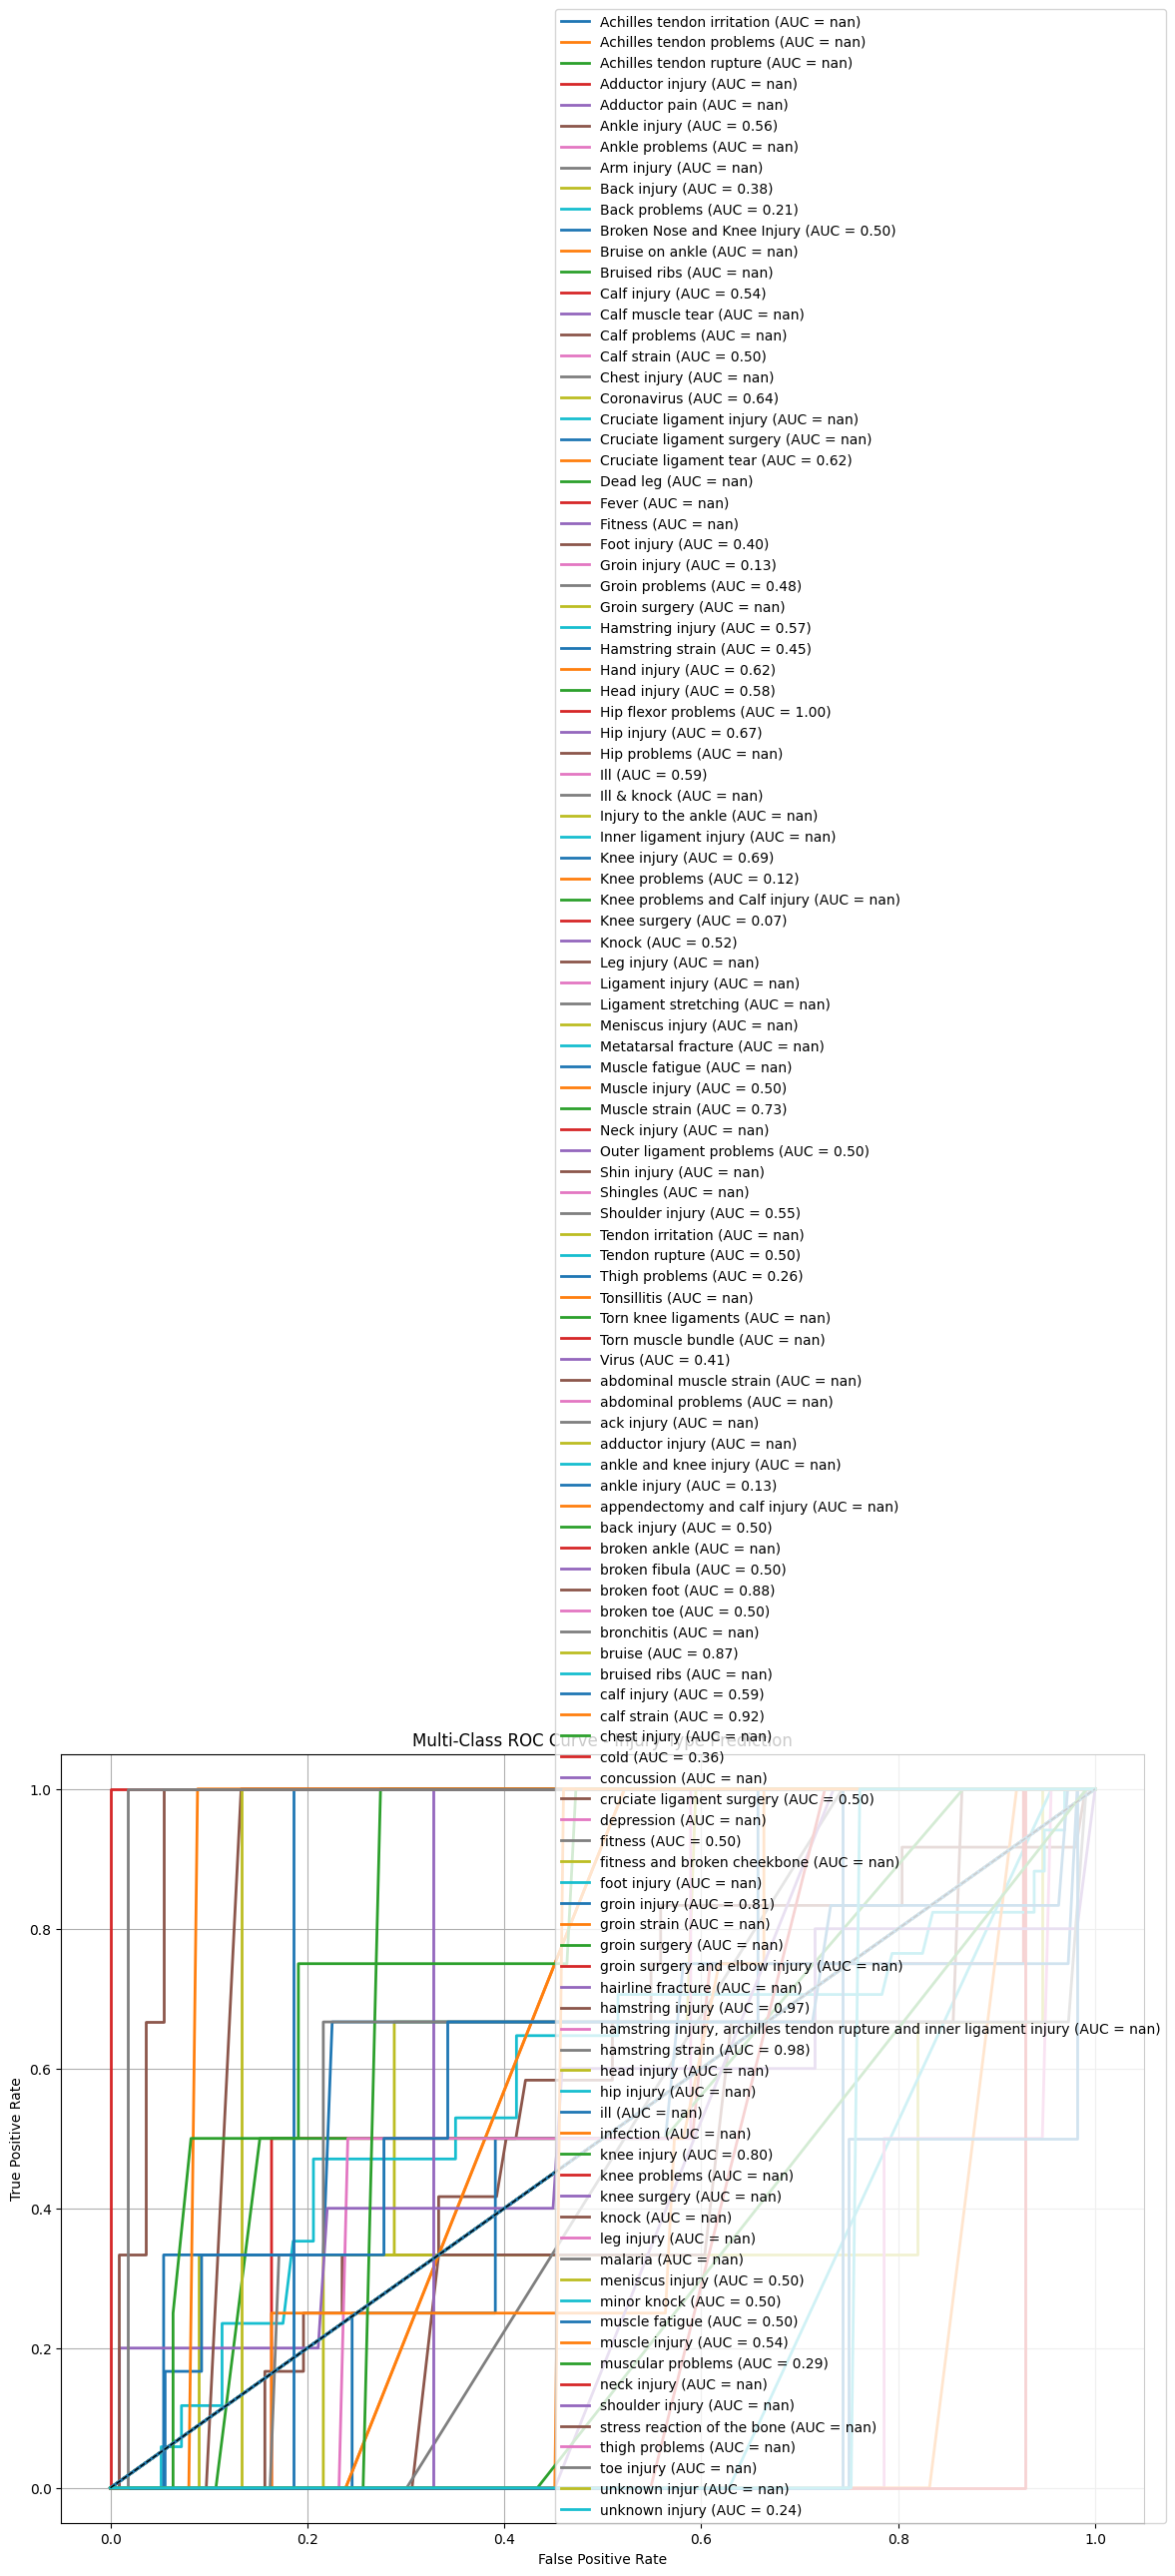

In [172]:

# Binarize the injury type labels
y_type_bin = label_binarize(y_type, classes=np.unique(y_type))
n_classes_type = y_type_bin.shape[1]

# Scale features
scaler_type = StandardScaler()
X_type_scaled = scaler_type.fit_transform(X_type)

# Split again for ROC plotting
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_type_scaled, y_type_bin, test_size=0.2, random_state=42)

# Choose model for ROC (e.g., Gradient Boosting)
model_roc = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, random_state=42))
model_roc.fit(X_train_bin, y_train_bin)
y_score = model_roc.predict_proba(X_test_bin)

# Compute ROC curves and AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes_type):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(14, 10))
colors = cycle(plt.cm.tab10.colors)
injury_label_names = LabelEncoder().fit(df['Injury']).classes_

for i, color in zip(range(n_classes_type), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{injury_label_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("Multi-Class ROC Curve - Injury Type Prediction")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', bbox_to_anchor=(1.02, 0), borderaxespad=0.)
plt.grid(True)
plt.tight_layout()
plt.show()

